# Model criticism: Not enough data augmentation

A trained model is not invariant to some transformations of input data that may appear in the test set.

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join("..", "..", ".."))
from batchflow import Pipeline, B, V, D
from batchflow.opensets import MNIST
from batchflow.models.tf import TFModel

from src import show_loss

%env CUDA_VISIBLE_DEVICES='6,7'

env: CUDA_VISIBLE_DEVICES='6,7'


## Dataset

For training and model performance assessment we use the MNIST dataset of images of size 28х28 pixels in greyscale.

In [2]:
mnist = MNIST()

## Model architecture

We use CNN with 3 convolutional layers and one dense layer in the end.

Loss function is categorical cross-entropy.

Optimizer is Adam with default parameters.

In [3]:
model_config = {
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    "initial_block/inputs": "images",
    "body": {"layout": "cpa" * 3, "filters": 10, "kernel_size": 3},
    "head": {"layout": "f", "units": D('num_classes')},
    "loss": "crossentropy",
    "optimizer": "Adam",
}

## Model training

We train model for 10 epochs with batch size 256.

In [4]:
N_EPOCH = 10
BATCH_SIZE = 256

In [5]:
template_train_pipeline = (
    Pipeline()
    .init_variable("loss_history", init_on_each_run=list)
    .init_model("dynamic", TFModel, "conv_model", config=model_config)
    .to_array()
    .train_model("conv_model", images=B("images"), labels=B("labels"),
                 fetches="loss", save_to=V("loss_history", mode="a"))
    .run_later(batch_size=BATCH_SIZE, n_epochs=N_EPOCH, shuffle=True, drop_last=True, bar=True)
)

train_pipeline = (mnist.train >> template_train_pipeline).run()

100%|██████████| 2340/2340 [03:20<00:00, 11.68it/s]


Loss function vs number of iterations plot comes to a plateau, which indicates the convergence of the learning process:

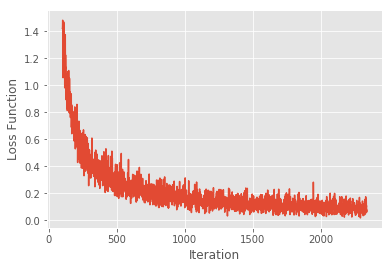

In [6]:
show_loss(train_pipeline.get_variable("loss_history"), skip=100)

## Model evaluation

Quality metric, in this case, is accuracy on the test set.

Metric evaluation pipeline:

In [7]:
template_test_pipeline = (
    Pipeline()
    .import_model("conv_model", train_pipeline)
    .init_variable("predictions")
    .init_variable("metrics", init_on_each_run=None)
    .to_array()
    .predict_model("conv_model", images=B("images"), labels=B("labels"),
                   fetches="predictions", save_to=V("predictions"))
    .gather_metrics("class", targets=B("labels"), predictions=V("predictions"),
                    fmt="logits", axis=-1, save_to=V("metrics", mode="u"))
    .run_later(batch_size=BATCH_SIZE, n_epochs=1, drop_last=False, bar=True)
)

test_pipeline = (mnist.test >> template_test_pipeline).run()

100%|██████████| 40/40 [00:02<00:00, 19.87it/s]


As you can see, the model learned to recognize numbers from the test data set with high accuracy:

In [8]:
test_pipeline.get_variable("metrics").evaluate("accuracy")

0.9704

## Model criticism

Let's see how the model will classify a digit shifted away from the center: the first picture shows an initial digit from the test set, the second and third shows the same digit, but shifted 4 pixels up-left and down-right, respectively.

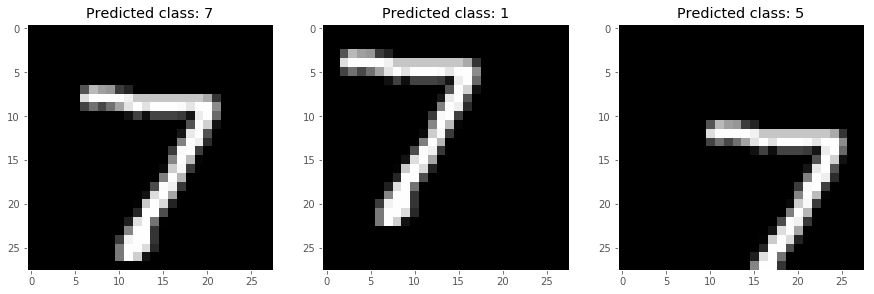

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

model = train_pipeline.get_model_by_name("conv_model")
offsets = [(0, 0), (-4, -4), (4, 4)]
for ax, offset in zip(axes, offsets):
    mnist.test.reset_iter()
    image = np.array(mnist.test.next_batch(1).shift(offset).images[0])
    image = image.reshape((1,) + image.shape + (1,))
    prediction = np.argmax(model.predict(fetches="predictions", images=image)[0])
    ax.set_title("Predicted class: {}".format(prediction))
    ax.imshow(image[0, :, :, 0], cmap="gray")
    ax.grid(False)
plt.show()

From these examples it is clear that the model is not invariant to the shift of the input image. The problem can be solved, for example, by adding augmentations — input transformations that will make the training sample more diverse. In this case, you need to add an action of randomly shifting the input image to the training pipeline.

At the same time, the augmentation scheme must be chosen carefully so that we do not add unnecessary or inappropriate transformations. For example, adding a turn at an angle close to 180 degrees will make the numbers 6 and 9 indistinguishable for the human eye and for the model as well.